# Exploring the Galaxy Halo connection of a MW-M31 merger remanent.
# Checking the stellar mass to halo mass relation of the MW-M31 merger remanent.
# The code will calculate the SHMR using the Moster et al. (2013) relation.

In [1]:
# import the needed stuff
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from matplotlib.colors import LogNorm
import scipy.optimize as so
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter
import os
from matplotlib.lines import Line2D
import matplotlib.animation as animation
import glob
from moster import AbundanceMatching
import matplotlib.patches as patches


## Plotting the density plot of the halo and disk particles at the above snapshot time


In [2]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    #one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    #three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    #four_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.97))
    #five_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.98))


    #print(four_sigma)

    # Array of Contour levels. Adjust according to the above
    levels = [two_sigma]#, three_sigma, four_sigma, five_sigma][::-1] #[one_sigma,
    
    # contour level labels  Adjust accoding to the above.
    strs =['0.80'][::-1] #['0.68','0.80', ,'0.95', '0.97','0.98'

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [3]:
#Only run it once! This code makes the merged file, with the M31 entry first, and the MW entry second.
# Paths for the files
M31_files = sorted(glob.glob("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M31/M31_*.txt"))
MW_files = sorted(glob.glob("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW/MW_*.txt"))
output_path = "/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW_M31_NEW/"
# Ensure both lists are of the same length
"""if len(M31_files) != len(MW_files):
    print("Error: M31 and MW file counts do not match.")
else:
    for m31_file, mw_file in zip(M31_files, MW_files):
        output_filename = os.path.basename(m31_file).replace("M31", "Merged")
        output_file = os.path.join(output_path, output_filename)  # Creating an output filename
    
        with open(m31_file, 'r') as m31, open(mw_file, 'r') as mw, open(output_file, 'w') as out:
            out.writelines(m31.readlines())  # Write full M31 file
            mw_lines = mw.readlines()[4:]   # Skip first three lines of MW file
            out.writelines(mw_lines)        # Append remaining MW lines

        print(f"Merged {m31_file} and {mw_file} -> {output_file}")"""


'if len(M31_files) != len(MW_files):\n    print("Error: M31 and MW file counts do not match.")\nelse:\n    for m31_file, mw_file in zip(M31_files, MW_files):\n        output_filename = os.path.basename(m31_file).replace("M31", "Merged")\n        output_file = os.path.join(output_path, output_filename)  # Creating an output filename\n    \n        with open(m31_file, \'r\') as m31, open(mw_file, \'r\') as mw, open(output_file, \'w\') as out:\n            out.writelines(m31.readlines())  # Write full M31 file\n            mw_lines = mw.readlines()[4:]   # Skip first three lines of MW file\n            out.writelines(mw_lines)        # Append remaining MW lines\n\n        print(f"Merged {m31_file} and {mw_file} -> {output_file}")'

In [ ]:

snapshot_number = np.arange(300, 800, 15)

fig, ax = plt.subplots(figsize=(12, 10))
cbar = None

# Function to update the plot for each snapshot
def update(frame):
    global cbar
    ax.clear()
    snap = snapshot_number[frame]
    # Load data for M31 and MW
    COMD_Merge = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW_M31_NEW/Merged_{snap}.txt", 2)
    COMP_Merge = COMD_Merge.COM_P(0.1, 2)
    #xD_Merger = COMD_Merge.x - COMP_Merge[0].value
    #yD_Merger = COMD_Merge.y - COMP_Merge[1].value
    
    # Load data for M31 and MW
    COMD_M31 = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M31/M31_{snap}.txt", 2)
    COMP_M31 = COMD_M31.COM_P(0.1, 2)
    xD_M31 = COMD_M31.x - COMP_Merge[0].value
    yD_M31 = COMD_M31.y - COMP_Merge[1].value
    
    COMD_MW = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW/MW_{snap}.txt", 2)
    COMP_MW = COMD_MW.COM_P(0.1, 2)
    xD_MW = COMD_MW.x - COMP_Merge[0].value
    yD_MW = COMD_MW.y - COMP_Merge[1].value

    # Plot 2D histograms
    hist1 = ax.hist2d(xD_M31, yD_M31, bins=150, norm=LogNorm(), cmap='inferno', label ='M31')
    hist2 = ax.hist2d(xD_MW, yD_MW, bins=150, norm=LogNorm(), cmap='cividis', label ='MW')
    #hist2 = ax.hist2d(xD_Merger, yD_Merger, bins=150, norm=LogNorm(), cmap='cividis')
    # Update colorbar
    """if cbar:
        cbar.remove()
    cbar = fig.colorbar(hist1[3], ax=ax)
    cbar.set_label("Number of disk particles per bin", fontsize=15)"""
    legend_elements = [Line2D([0], [0], color='red', lw=3, label='M31'),
                       Line2D([0], [0], color='blue', lw=3, label='MW')]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=15)
    
    ax.set_xlabel("y kpc", fontsize=22)
    ax.set_ylabel("x kpc", fontsize=22)
    # Calculate the min and max for the x and y axes to auto-zoom
    all_x = np.concatenate([xD_M31, xD_MW])
    all_y = np.concatenate([yD_M31, yD_MW])
    
    # Determine the zoom level (min and max limits) for both x and y axes
    margin = 50  # Add a small margin around the data
    ax.set_xlim(np.min(all_x) - margin, np.max(all_x) + margin)
    ax.set_ylim(np.min(all_y) - margin, np.max(all_y) + margin)
    ax.set_title(f"Snapshot {snap}", fontsize=20)
    #ax.legend(loc='upper right', fontsize=15)
    # Adjust tick label size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size

ani = animation.FuncAnimation(fig, update, frames=len(snapshot_number), repeat=True)
# Save animation as MP4
# Specify the ffmpeg writer
ani.save("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/ResearchAssignment/ResearchAssignment5/m31_animation_350.mp4")

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

snap = 700
# Initialize the COM using the merger file. # Disk particles only.
COMD_Merge = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW_M31_NEW/Merged_{snap}.txt", 2)
COMP_Merge_p = COMD_Merge.COM_P(0.1, 2)
#positions of particles wrt COM
xD_Merger = COMD_Merge.x - COMP_Merge_p[0].value
yD_Merger = COMD_Merge.y - COMP_Merge_p[1].value
zD_Merger = COMD_Merge.z - COMP_Merge_p[2].value

# Initialize the COM of M31. # Disk particles only.
COMD_M31 = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/M31/M31_{snap}.txt", 2)
COMP_M31 = COMD_M31.COM_P(0.1, 2)
#positions of particles wrt COM
xD_M31 = COMD_M31.x - COMP_Merge_p[0].value
yD_M31 = COMD_M31.y - COMP_Merge_p[1].value
zD_M31 = COMD_M31.z - COMP_Merge_p[2].value 

# Initialize the COM of MW. # Disk particles only.
COMD_MW = CenterOfMass(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW/MW_{snap}.txt", 2)
COMP_MW = COMD_MW.COM_P(0.1, 2)
#positions of particles wrt COM
xD_MW = COMD_MW.x - COMP_Merge_p[0].value
yD_MW = COMD_MW.y - COMP_Merge_p[1].value
zD_MW = COMD_MW.z - COMP_Merge_p[2].value

# Plot 2D histograms
hist1 = ax.hist2d(xD_M31, yD_M31, bins=150, norm=LogNorm(), cmap='inferno', label ='M31')
hist2 = ax.hist2d(xD_MW, yD_MW, bins=150, norm=LogNorm(), cmap='cividis', label ='MW')
#hist3 = ax[1].hist2d(xD_Merger, yD_Merger, bins=150, norm=LogNorm(), cmap='cividis')
# Update colorbar
#contour1 = density_contour(xD_MW, yD_MW, 80, 80, ax=ax[0], colors=['g', "r"])
contour2 = density_contour(xD_Merger, yD_Merger, 80, 80, ax=ax, colors=['y', "w"])

cbar = fig.colorbar(hist1[3], ax=ax)
cbar.set_label("Number of disk particles per bin", fontsize=15)
legend_elements = [Line2D([0], [0], color='red', lw=3, label='M31'),
                    Line2D([0], [0], color='blue', lw=3, label='MW')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=15)

ax.set_xlabel("y kpc", fontsize=22)
ax.set_ylabel("x kpc", fontsize=22)
# Calculate the min and max for the x and y axes to auto-zoom
all_x = np.concatenate([xD_M31, xD_MW])
all_y = np.concatenate([yD_M31, yD_MW])

# Determine the zoom level (min and max limits) for both x and y axes
margin = 10  # Add a small margin around the data
ax.set_xlim(np.min(all_x) - margin, np.max(all_x) + margin)
ax.set_ylim(np.min(all_y) - margin, np.max(all_y) + margin)
#ax[1].set_xlim(np.min(all_x) - margin, np.max(all_x) + margin)
#ax[1].set_ylim(np.min(all_y) - margin, np.max(all_y) + margin)
#ax.set_xlim(-20, 20)
#ax.set_ylim(-15, 15)
ax.set_title(f"Snapshot {snap}", fontsize=20)
#ax.legend(loc='upper right', fontsize=15)
# Adjust tick label size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.savefig("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/ASTR400B/ResearchAssignment/ResearchAssignment5/700_merge")
plt.show()

## We use the radius from above to make a shphere from the center of merger and  include all the disk+buldge particles within the sphere

## getting the desired Halo particles

In [4]:
class Merger:
    def __init__(self, filename):
        self.filename = filename
        p_c = 8.5 * 10**-27 * u.kg/u.m**3 
        p_c = p_c.to(u.Msun / u.kpc**3)
        self.h_density_lim = 200*p_c
        _, _, self.data = Read(self.filename)
    
    def find_confidence_interval(self, x, pdf, confidence_level):
        return pdf[pdf > x].sum() - confidence_level

    def __find_dist_in_contour__(self, xdata, ydata, nbins_x =150, nbins_y =150, sigma_level = 80):
        """
        Find the data points that fall within a specific confidence contour level.
        
        Parameters
        ----------
        xdata : numpy.ndarray
            x-coordinates of data pointsg
        ydata : numpy.ndarray
            y-coordinates of data points
        zdata : numpy.ndarray
            z-values associated with (x, y) points
        nbins_x : int
            Number of bins along x dimension
        nbins_y : int
            Number of bins along y dimension
        sigma_level : str, optional
            The confidence level to use ("one_sigma", "two_sigma", etc.)
            
        Returns
        -------
        numpy.ndarray
            Array of (x, y, z) data points within the specified contour
        """
        # Create the 2D histogram
        H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x, nbins_y), density=True)
        

        # Calculate the bin sizes
        x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1, nbins_x))
        y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y, 1))
        
        # Calculate the probabilit mass
        pm = (H * (x_bin_sizes * y_bin_sizes)) #actual probability that a point falls in the bim
        # Get the bin centers
        X, Y = 0.5 * (xedges[1:] + xedges[:-1]), 0.5 * (yedges[1:] + yedges[:-1])
        Z = pm.T  # Transpose to align with (X, Y)
        # Calculate contour threshold
        threshold = so.brentq(self.find_confidence_interval, 0., 1., args=(pm, sigma_level/100))
        # Find all points where Pm is above the threshold (inside the contour)
        in_contour = Z >= threshold
        # Extract the indices of the bins inside the contour
        contour_indices = np.argwhere(in_contour)
        # Convert bin indices to actual (x, y) coordinates
        x_contour = X[contour_indices[:, 1]]  
        y_contour = Y[contour_indices[:, 0]] 

        self.max_dist = np.max(np.sqrt(x_contour**2 + y_contour**2))

    
    def __stellar_mass_needs__(self):
        COMD_Merge = CenterOfMass(self.filename, 2)
        self.COMP_Merge_p = COMD_Merge.COM_P(0.1, 2)
        
        #create an array to store indexes of particles of desired Ptype                                
        index = np.where((self.data['type'] == 2) | (self.data['type'] == 3))
        self.smp_mass = self.data['m'][index] #stellar mass particles
        self.x_pos = self.data['x'][index] - self.COMP_Merge_p[0].value #COMP values for disk and buldge are basically the same since the merger has stabilized.
        self.y_pos = self.data["y"][index] - self.COMP_Merge_p[1].value 
        self.z_pos = self.data["z"][index] - self.COMP_Merge_p[2].value
        dist_array = self.x_pos**2 + self.y_pos**2 + self.z_pos**2
        self.dist_array = np.sqrt(dist_array)
        
    
    def prop_stellar_mass(self):
        self.__stellar_mass_needs__()
        self.__find_dist_in_contour__(self.x_pos, self.y_pos)
        print(f"furthest distance in 0.8 contour level: {self.max_dist*u.kpc:.2f}")
        
        
        #positions and velocities
        # getting indexes of particles within the max distance
        idx_dist_3d = np.where(self.dist_array <= self.max_dist)[0]
        # x,y ,z position withing the sphere and the position correspond to that in the merged files.
        x_3d = self.x_pos[idx_dist_3d] + self.COMP_Merge_p[0].value #adding COMP to get the original positions
        y_3d = self.y_pos[idx_dist_3d] + self.COMP_Merge_p[1].value
        z_3d = self.z_pos[idx_dist_3d] + self.COMP_Merge_p[2].value

        self.m_3d = self.smp_mass[idx_dist_3d]
        return x_3d , y_3d, z_3d, self.m_3d # position dont hold much value going forward, but mass does.
    
    def total_stellar_mass(self):
        self.prop_stellar_mass()
        self.total_stellar = np.sum(self.m_3d) * 1e10
        return self.total_stellar
    
    def density_halo(self):
        self.COMD_halo = CenterOfMass(self.filename, 1)
        self.COMp_halo = self.COMD_halo.COM_P(0.1, 1)
        index_halo = np.where(self.data['type'] == 1)
        self.m = self.data['m'][index_halo]
        self.x = self.data['x'][index_halo] - self.COMp_halo[0].value
        self.y = self.data["y"][index_halo] - self.COMp_halo[1].value
        self.z = self.data["z"][index_halo] - self.COMp_halo[2].value
        self.r = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        # store the mass of each particle within the radii
        self.radii = np.sort(self.r.copy())
        particle_mass_enclosed_array = np.zeros(len(self.radii))
        # identify particles that are enclodes within the radii
        all_radii = self.r.copy()
        # loop over the radii
        for i in range(len(self.radii)):
            # get the mass of those particles in sol mass
            particle_mass_enclosed_array[i] = np.sum(self.m[np.where(all_radii < self.radii[i])]) * 1e10

        #getting the density at each radius
        self.density_array = particle_mass_enclosed_array / (4/3 * np.pi * self.radii**3)
    
    def r200(self):
        self.density_halo()
        # finding the Halo density point which is closest to the R200 limit
        diff_array = abs(self.density_array - self.h_density_lim.value)
        # the intercept will have a value of 0.
        idx_halo = np.where(diff_array == np.min(diff_array))[0]
        self.desired_halo_rad = self.radii[idx_halo][0]
        print(f"Desired halo radius: {self.desired_halo_rad:.2f} kpc")
        return self.desired_halo_rad
    
    def prop_halo_mass(self):
        self.r200()
        #get all the particles within this radius
        idx_halo = np.where(self.r <= self.desired_halo_rad)[0]
        # x,y ,z position withing the sphere and the position correspond to that in the merged files.
        x_halo = self.x[idx_halo] + self.COMp_halo[0].value  
        y_halo = self.y[idx_halo] + self.COMp_halo[1].value  
        z_halo = self.z[idx_halo] + self.COMp_halo[2].value
        self.m_halo = self.m[idx_halo]

        return x_halo , y_halo, z_halo, self.m_halo
    
    def total_halo_mass(self):
        self.prop_halo_mass()
        self.total_halo_mass = np.sum(self.m_halo) * 1e10
        return self.total_halo_mass  
        

                                                                                                     


## MW M31 700 snapshot merger

In [6]:
MW_M31_700 = Merger("/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW_M31_NEW/Merged_700.txt")


In [7]:
calc_Merger_700_sm = MW_M31_700.total_stellar_mass()
r200_Merger_700_hm = MW_M31_700.total_halo_mass()

furthest distance in 0.8 contour level: 19.98 kpc
Desired halo radius: 267.56 kpc


In [8]:
print(f"Total stellar mass of the merger: {calc_Merger_700_sm:.2e} Msun")
print(f"Total halo mass of the merger: {r200_Merger_700_hm:.2e} Msun")

Total stellar mass of the merger: 1.60e+11 Msun
Total halo mass of the merger: 2.02e+12 Msun


In [9]:
sum(MW_M31_700.m_halo)/sum(MW_M31_700.m)

0.5173255294656085

/var/folders/km/7nz8l5dn7wn9ld1xzqkw5v400000gn/T/ipykernel_30966/1314792049.py:25: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = ax1.legend(loc='upper left', frameon=True, fontsize=18)


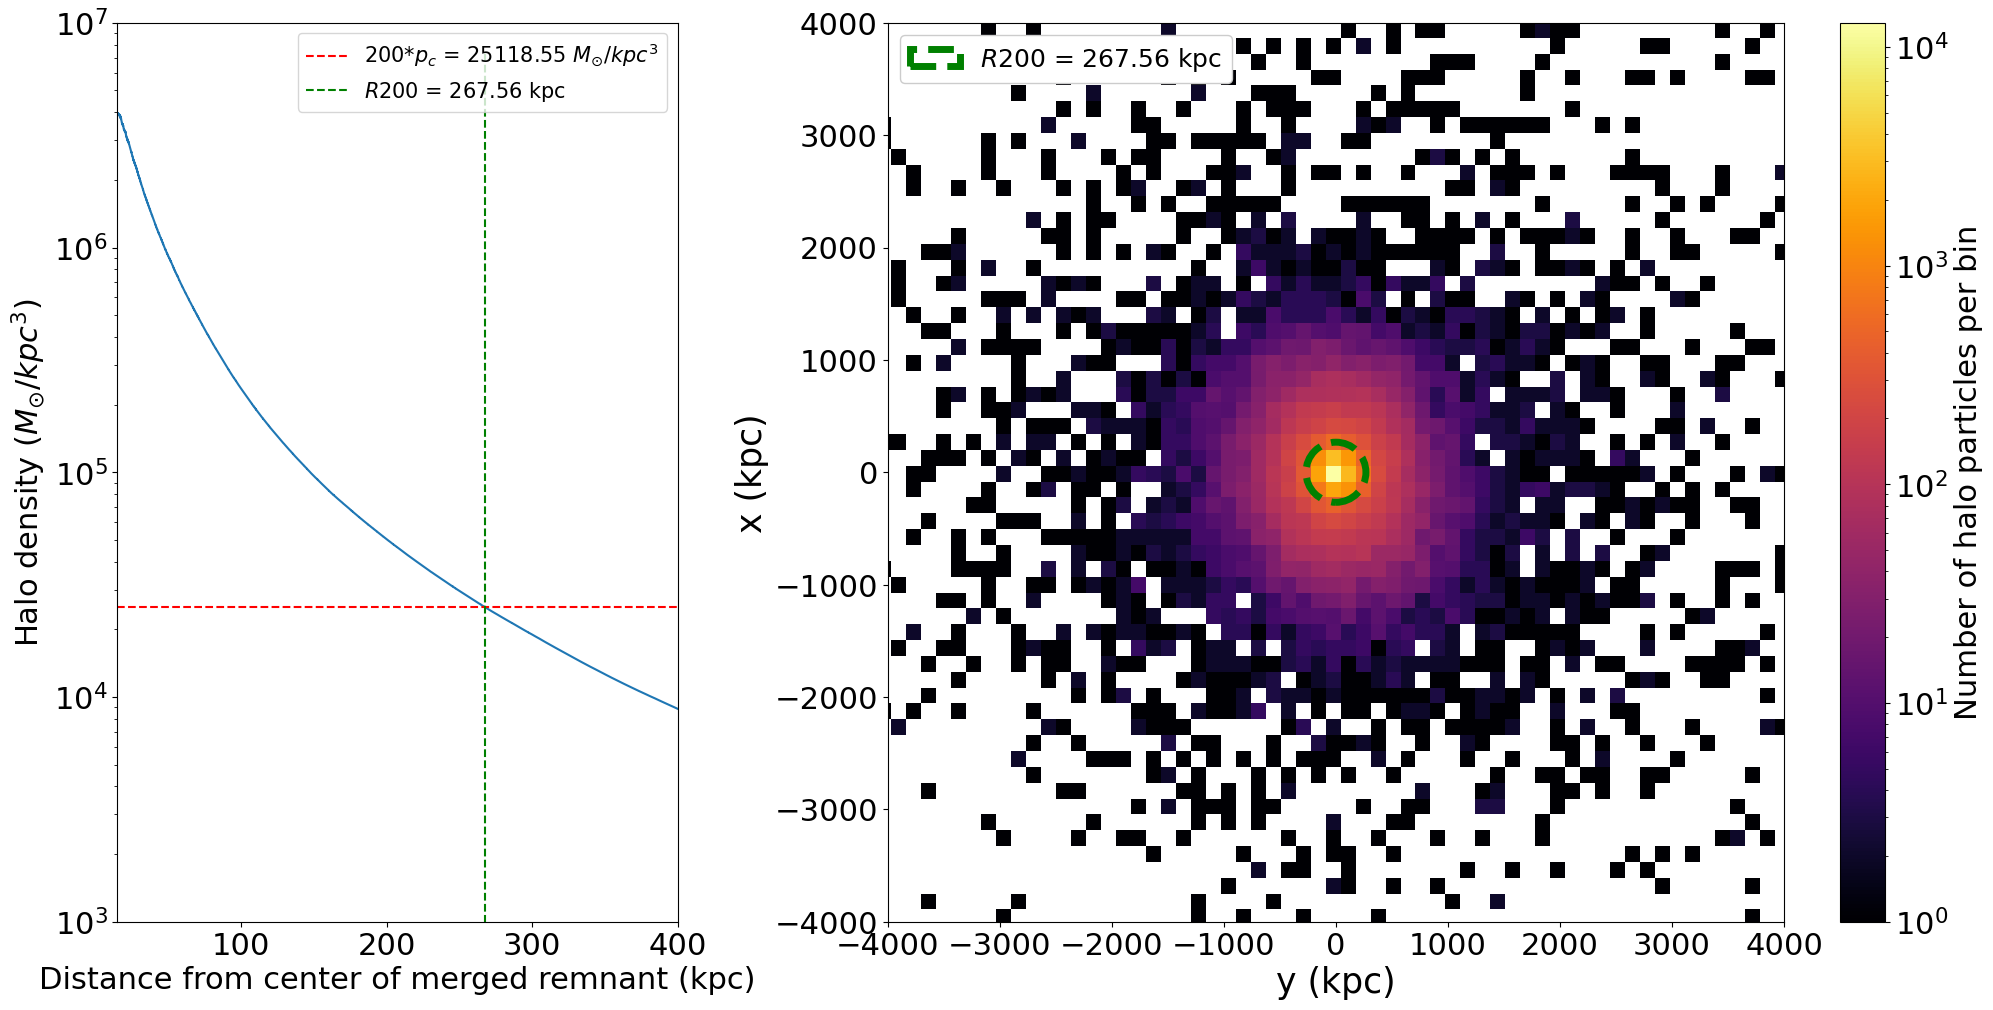

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 2]})
ax, ax1 = axs

# Left plot
ax.plot(MW_M31_700.radii, MW_M31_700.density_array)
ax.axhline(MW_M31_700.h_density_lim.value, color='red', linestyle='--', label=fr'200*$p_c$ = {MW_M31_700.h_density_lim.value:.2f} $M_{{\odot}}/kpc^3$')
ax.set_xlabel("Distance from center of merged remnant (kpc)", fontsize=22)
ax.set_ylabel("Halo density ($M_{{\odot}}/kpc^3$)", fontsize=22)
ax.set_xlim(15, 400)
ax.set_ylim(1e3, 1e7)
ax.set_yscale('log')
ax.vlines(MW_M31_700.desired_halo_rad, min(MW_M31_700.density_array), max(MW_M31_700.density_array), color='green', linestyle='--', label=fr'$R{{200}}$ = {MW_M31_700.desired_halo_rad:.2f} kpc')
ax.legend(fontsize=15)

# Right plot
hist1 = ax1.hist2d(MW_M31_700.x, MW_M31_700.y, bins=150, norm=LogNorm(), cmap='inferno', label='Merger halo density plot')
circle = patches.Circle((0, 0), MW_M31_700.desired_halo_rad,linewidth = 5, color='green', linestyle='--', fill=False, label=fr'$R{{200}}$ = {MW_M31_700.desired_halo_rad:.2f} kpc')
ax1.add_patch(circle)
ax1.set_xlabel("y (kpc)", fontsize=25)
ax1.set_ylabel("x (kpc)", fontsize=25)
cbar = fig.colorbar(hist1[3], ax=ax1)
cbar.set_label("Number of halo particles per bin", fontsize=22)
ax1.set_xlim(-4000, 4000)
ax1.set_ylim(-4000, 4000)
legend = ax1.legend(loc='upper left', frameon=True, fontsize=18) 
legend.get_frame().set_facecolor('white')  # Set the legend background color to white
legend.get_frame().set_alpha(1.0)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(wspace=0.25)  # Increase the horizontal space between plots
ax.tick_params(axis='both', which='major', labelsize=22)
ax1.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22)

plt.show()

## establishing the moster relation

In [75]:
# Now we can use the Moster et al. (2013) relation to find the expected stellar mass for our calculated halo mass.
MW_M31 = AbundanceMatching(r200_Merger_700_hm, 0)
expected_stellar_mass = MW_M31.StellarMass() 
print(f"Expected stellar mass: {expected_stellar_mass:.2e} Msun")
print(f"calculated stellar mass: {calc_Merger_700_sm:.2e} Msun")


Expected stellar mass: 5.01e+10 Msun
calculated stellar mass: 1.60e+11 Msun


In [76]:
default = AbundanceMatching(r200_Merger_700_hm, 0)
def_exp_stellar = default.StellarMass()
print(f"Expected stellar mass: {def_exp_stellar:.2e} Msun")

Expected stellar mass: 5.01e+10 Msun


In [ ]:
mh = np.logspace(10, 15, 1000)
# Define Instances of the Class for each redshift
MosterZ0 = AbundanceMatching(mh,0) # z = 0

In [6]:
scatter = MosterZ0.error()

In [7]:
scatter[1]

array([1.28892387e+07, 1.32226288e+07, 1.35646195e+07, 1.39154315e+07,
       1.42752913e+07, 1.46444311e+07, 1.50230889e+07, 1.54115088e+07,
       1.58099413e+07, 1.62186429e+07, 1.66378769e+07, 1.70679131e+07,
       1.75090284e+07, 1.79615063e+07, 1.84256379e+07, 1.89017214e+07,
       1.93900627e+07, 1.98909753e+07, 2.04047808e+07, 2.09318086e+07,
       2.14723969e+07, 2.20268921e+07, 2.25956493e+07, 2.31790328e+07,
       2.37774158e+07, 2.43911812e+07, 2.50207213e+07, 2.56664382e+07,
       2.63287444e+07, 2.70080626e+07, 2.77048260e+07, 2.84194788e+07,
       2.91524762e+07, 2.99042851e+07, 3.06753837e+07, 3.14662624e+07,
       3.22774238e+07, 3.31093829e+07, 3.39626678e+07, 3.48378195e+07,
       3.57353928e+07, 3.66559558e+07, 3.76000913e+07, 3.85683961e+07,
       3.95614821e+07, 4.05799762e+07, 4.16245209e+07, 4.26957746e+07,
       4.37944120e+07, 4.49211243e+07, 4.60766199e+07, 4.72616246e+07,
       4.84768820e+07, 4.97231542e+07, 5.10012217e+07, 5.23118844e+07,
      

In [3]:
#how many sigma away from the mean the MW/M31/Merger Remnant lie
def sigma_distance(halo_mass ,expected_stellar_mass, calc_stellar_mass):
    # Calculate the mean and standard deviation of the Moster relation
    merg = AbundanceMatching(halo_mass, 0)
    mean = merg.StellarMass()
    up_lim_scat, _ = merg.error()
    
    # Calculate the z-score for the calculated stellar mass
    z_score = (calc_stellar_mass - expected_stellar_mass) / (up_lim_scat - expected_stellar_mass)
    return z_score
# Calculate the z-scores for the calculated stellar masses



furthest distance in 0.8 contour level: 19.98 kpc
Desired halo radius: 267.56 kpc
Expected stellar mass of merger: 5.01e+10 Msun
calculated stellar mass of merger: 1.60e+11 Msun
z-score for merger at 10.00 Gyr: 3.47
furthest distance in 0.8 contour level: 17.19 kpc
Desired halo radius: 224.76 kpc
Expected stellar mass M31: 3.83e+10 Msun
calculated stellar mass M31: 1.09e+11 Msun
Total halo mass of M31: 1.19e+12 Msun
z-score for M31 at 0.00 Gyr: 4.29
furthest distance in 0.8 contour level: 11.46 kpc
Desired halo radius: 227.03 kpc
Expected stellar mass MW: 3.89e+10 Msun
calculated stellar mass MW: 6.61e+10 Msun
Total halo mass of MW: 1.23e+12 Msun
z-score for MW at 0.00 Gyr: 1.57


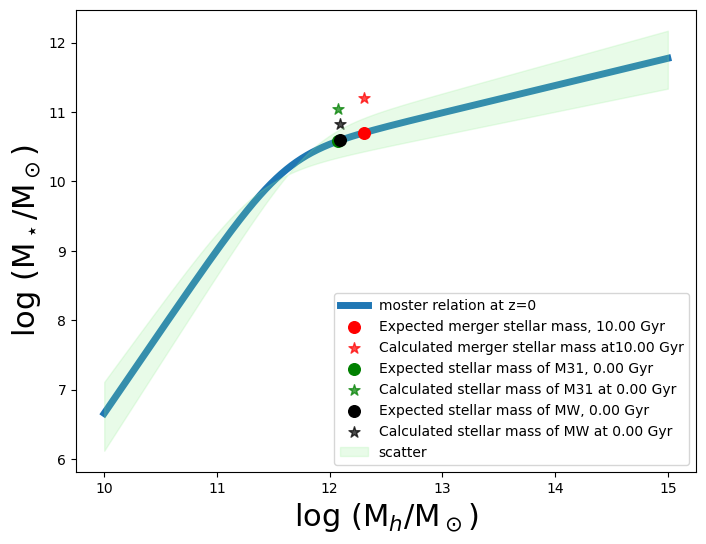

In [4]:
# plotting the moster and the expected and calculated stellar mass
fig, ax = plt.subplots(figsize=(8, 6))
# plot the Moster relation
mh = np.logspace(10, 15, 1000)
# Define Instances of the Class for each redshift
MosterZ0 = AbundanceMatching(mh,0) # z = 0
upper_lim_sm, lower_lim_sm = MosterZ0.error()
# Plot z = 0
plt.plot(np.log10(mh), np.log10(MosterZ0.StellarMass()),linewidth = 5, label='moster relation at z=0',zorder=1)

sigma = MosterZ0.compute_sigma_m()
#plt.fill_between(np.log10(mh), np.log10(MosterZ0.StellarMass() + sigma), np.log10(MosterZ0.StellarMass() - sigma), color='gray', alpha=0.5, label='scatter error prop')
for i in [700]:
    # plot the expected stellar mass
    MW_M31_700 = Merger(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/MW_M31_NEW/Merged_{i}.txt")

    calc_Merger_700_sm = MW_M31_700.total_stellar_mass()
    r200_Merger_700_hm = MW_M31_700.total_halo_mass()
    MW_M31 = AbundanceMatching(r200_Merger_700_hm, 0)
    expected_merger_stellar_mass = MW_M31.StellarMass() 
    plt.scatter(np.log10(r200_Merger_700_hm), np.log10(expected_merger_stellar_mass), marker = "o",color = "r", s = 70,label=f'Expected merger stellar mass, {i*14.28/1000*u.Gyr:.2f}',zorder=2) 
    #plt.scatter(np.log10(total_halo), np.log10(def_exp_stellar), color='green', label='all halo mass, moster stellar mass',zorder=2) 
    #plt.scatter(np.log10(total_halo), np.log10(total_stellar), color='green', label='all of halao mass, all calc stellar mass',zorder=2) 
    z_score_Merger = sigma_distance(r200_Merger_700_hm, expected_merger_stellar_mass, calc_Merger_700_sm)
    print(f"Expected stellar mass of merger: {expected_merger_stellar_mass:.2e} Msun")
    print(f"calculated stellar mass of merger: {calc_Merger_700_sm:.2e} Msun")
    print(f"z-score for merger at {i*14.28/1000*u.Gyr:.2f}: {z_score_Merger:.2f}")
    # plot the calculated stellar mass
    plt.scatter(np.log10(r200_Merger_700_hm), np.log10(calc_Merger_700_sm), marker = "*", color = "r",s = 70, label=f'Calculated merger stellar mass at{i*14.28/1000*u.Gyr:.2f}', alpha=0.7)

    #plt.vlines(x=np.log10(total_halo_mass), ymin=min(np.log10(MosterZ0.StellarMass())), ymax=max(np.log10(MosterZ0.StellarMass())), color='black', linestyle='--', label='r200 Halo mass')
#plt.vlines(x=np.log10(total_halo),  ymin=min(np.log10(MosterZ0.StellarMass())), ymax=max(np.log10(MosterZ0.StellarMass())), color='yellow', linestyle='--', label='all Halo mass')

total_expected_sm_0 = 0
total_calc_sm_0 = 0
total_halo = 0
for galaxy, color in zip(["M31", "MW"], ["g", "k"]):
    for i in [000]:
        #add a string of the filenumber to the value “000”
        ilbl = "000"+ str(i)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        # plot the expected stellar mass
        MW = Merger(f"/Users/swapnaneeldey/Desktop/ASTR400Bfiles/{galaxy}/{galaxy}_{ilbl}.txt")

        calc_MW_sm = MW.total_stellar_mass()
        r200_MW_hm = MW.total_halo_mass()
        MW_mos = AbundanceMatching(r200_MW_hm, 0)
        expected_stellar_mass = MW_mos.StellarMass() 
        print(f"Expected stellar mass {galaxy}: {expected_stellar_mass:.2e} Msun")
        print(f"calculated stellar mass {galaxy}: {calc_MW_sm:.2e} Msun")
        print(f"Total halo mass of {galaxy}: {r200_MW_hm:.2e} Msun")
        plt.scatter(np.log10(r200_MW_hm), np.log10(expected_stellar_mass), color = color, marker = "o", s = 70, label=f'Expected stellar mass of {galaxy}, {i*14.28/1000*u.Gyr:.2f}',zorder=2) 
        #plt.scatter(np.log10(total_halo), np.log10(def_exp_stellar), color='green', label='all halo mass, moster stellar mass',zorder=2) 
        #plt.scatter(np.log10(total_halo), np.log10(total_stellar), color='green', label='all of halao mass, all calc stellar mass',zorder=2) 
        z_score_MW = sigma_distance(r200_MW_hm, expected_stellar_mass, calc_MW_sm)
        print(f"z-score for {galaxy} at {i*14.28/1000*u.Gyr:.2f}: {z_score_MW:.2f}")
        # plot the calculated stellar mass
        plt.scatter(np.log10(r200_MW_hm), np.log10(calc_MW_sm),color = color,marker = "*", s = 70,label=f'Calculated stellar mass of {galaxy} at {i*14.28/1000*u.Gyr:.2f}', alpha=0.7)
    total_expected_sm_0 += expected_stellar_mass
    total_calc_sm_0 += calc_MW_sm
    total_halo += r200_MW_hm

#plt.scatter(np.log10(total_halo), np.log10(total_expected_sm_0), color='green', label='all halo mass, moster stellar mass at 0',zorder=2)
#plt.scatter(np.log10(total_halo), np.log10(total_calc_sm_0), color='green', label='all of halo mass, all calc stellar mass at 0',zorder=2)
plt.fill_between(np.log10(mh), np.log10(upper_lim_sm), np.log10(lower_lim_sm), color='lightgreen', alpha=0.2, label='scatter')

plt.xlabel('log (M$_h$/M$_\odot$)',fontsize=22) 
plt.ylabel('log (M$_\star$/M$_\odot$)', fontsize=22)
plt.legend(fontsize = 10)

In [9]:
sigma[0], MosterZ0.StellarMass()[0]

(4314976.028037822, 4551902.73037931)

In [6]:
np.log10(MosterZ0.StellarMass() + sigma), np.log10(MosterZ0.StellarMass() - sigma)

(array([ 6.94777077,  6.95941958,  6.97106849,  6.98271748,  6.99436656,
         7.00601573,  7.01766497,  7.02931429,  7.04096368,  7.05261313,
         7.06426264,  7.0759122 ,  7.08756182,  7.09921148,  7.11086118,
         7.12251091,  7.13416068,  7.14581046,  7.15746026,  7.16911007,
         7.18075988,  7.19240969,  7.20405949,  7.21570927,  7.22735903,
         7.23900875,  7.25065844,  7.26230807,  7.27395765,  7.28560716,
         7.29725661,  7.30890596,  7.32055523,  7.3322044 ,  7.34385345,
         7.35550239,  7.36715119,  7.37879985,  7.39044836,  7.40209671,
         7.41374488,  7.42539286,  7.43704064,  7.44868822,  7.46033557,
         7.47198268,  7.48362954,  7.49527614,  7.50692246,  7.51856848,
         7.5302142 ,  7.5418596 ,  7.55350465,  7.56514935,  7.57679368,
         7.58843762,  7.60008116,  7.61172427,  7.62336693,  7.63500914,
         7.64665087,  7.65829209,  7.6699328 ,  7.68157296,  7.69321256,
         7.70485158,  7.71648999,  7.72812777,  7.7